In [1]:
from transformers import ViTImageProcessor
from src import *
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pickle

external_path=''

In [26]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('aaraki/vit-base-patch16-224-in21k-finetuned-cifar10')

In [3]:
from datasets import load_dataset

dataset = load_dataset("uoft-cs/cifar10")

train_set = dataset["train"]
test_set = dataset["test"]

concepts=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [28]:
def consistency_error(positive_concept,negative_concept,layer_1,layer_2,concept_vector_type='cav',gamma=5e-3,verbose=True):
    if layer_1>=layer_2:
        raise ValueError('layer_1 should be strictly less than layer_2')
    if concept_vector_type=='cav':
        concept_vector_1=torch.load(f'{external_path}\\concept_activation_vectors\\{layer_1}\\{positive_concept}_{negative_concept}.pt')
        concept_vector_2=torch.load(f'{external_path}\\concept_activation_vectors\\{layer_2}\\{positive_concept}_{negative_concept}.pt')
    elif concept_vector_type=='cbv':
        concept_vector_1=torch.load(f'{external_path}\\concept_boundary_vectors\\{layer_1}\\{positive_concept}_{negative_concept}.pt')
        concept_vector_2=torch.load(f'{external_path}\\concept_boundary_vectors\\{layer_2}\\{positive_concept}_{negative_concept}.pt')

    for k in range(1,11):
        if k==1:
            positive_concept_activations_layer_1=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer_2}_{k}.pt')
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer_2}_{k}.pt')
            positive_concept_activations_layer_1=torch.cat([positive_concept_activations_layer_1,activations])

    for k in range(1,11):
        if k==1:
            positive_concept_activations_layer_2=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer_2}_{k}.pt')
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer_2}_{k}.pt')
            positive_concept_activations_layer_2=torch.cat([positive_concept_activations_layer_2,activations])

    average_norm_layer_1=0
    count=0
    for k in range(positive_concept_activations_layer_1.shape[0]):
        average_norm_layer_1+=torch.norm(positive_concept_activations_layer_1[k,:])
        count+=1
    average_norm_layer_1/=count
    concept_vector_1_norm=torch.norm(concept_vector_1)

    average_norm_layer_2=0
    count=0
    for k in range(positive_concept_activations_layer_2.shape[0]):
        average_norm_layer_2+=torch.norm(positive_concept_activations_layer_2[k,:])
        count+=1
    average_norm_layer_2/=count
    concept_vector_2_norm=torch.norm(concept_vector_2)

    perturbation_coefficient_layer_1=gamma*average_norm_layer_1/concept_vector_1_norm
    perturbation_coefficient_layer_2=gamma*average_norm_layer_2/concept_vector_2_norm

    class_test_instances_file=open(f'{external_path}\\concept_correctly_classified_indices','rb')
    class_test_instances=pickle.load(class_test_instances_file)
    class_test_instances_file.close()

    positive_concept_instances=test_set[class_test_instances[positive_concept]]['img']

    epsilon_consistency=0
    prev_epsilon_consistency=0
    count=0
    low_diff_count=0
    if verbose:
        progress_bar=tqdm(enumerate(positive_concept_instances),total=len(positive_concept_instances))
    else:
        progress_bar=enumerate(positive_concept_instances)
    for k,positive_instance in progress_bar:
        instance_processed=processor(images=positive_instance,return_tensors='pt')['pixel_values']
        projected_activation=model(pixel_values=instance_processed,perturb=True,perturbed_layer=layer_1,perturbation=perturbation_coefficient_layer_1*concept_vector_1,output_class_activation_token_layer=layer_2).hidden_states[0]
        epsilon_consistency+=torch.norm(positive_concept_activations_layer_2[k,:]+perturbation_coefficient_layer_2*concept_vector_2-projected_activation)/(gamma*average_norm_layer_2)
        count+=1
        if verbose:
            progress_bar.set_description(f'...Consistency of {concept_vector_type} {positive_concept}-{negative_concept} from Layer {layer_1} to {layer_2}...{(epsilon_consistency/count):.4f}')
        if torch.abs(epsilon_consistency/count-prev_epsilon_consistency)<5e-4:
            low_diff_count+=1
        if low_diff_count>5:
            break
        prev_epsilon_consistency=epsilon_consistency/count
    epsilon_consistency/=count
    return epsilon_consistency.item()

In [34]:
layer_1s=[2,5,7]
layer_2=11

pbar=tqdm(layer_1s)
for layer_1 in pbar:
    if not(os.path.exists(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}')):
        os.makedirs(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}')
    if os.path.exists(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cavs'):
        consistency_errors_cavs_file=open(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cavs','rb')
        consistency_errors_cavs=pickle.load(consistency_errors_cavs_file)
        consistency_errors_cavs_file.close()
    else:
        consistency_errors_cavs={}
    if os.path.exists(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cbvs'):
        consistency_errors_cbvs_file=open(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cbvs','rb')
        consistency_errors_cavs=pickle.load(consistency_errors_cbvs_file)
        consistency_errors_cbvs_file.close()
    else:
        consistency_errors_cbvs={}
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            if not(f'{positive_concept}_{negative_concept}' in consistency_errors_cavs.keys()):
                pbar.set_description(f'Layer {layer_1} to {layer_2}: {positive_concept}_{negative_concept} CAV')
                consistency_errors_cavs[f'{positive_concept}_{negative_concept}']=consistency_error(positive_concept,negative_concept,layer_1,layer_2,concept_vector_type='cav',verbose=False)
            if not(f'{positive_concept}_{negative_concept}' in consistency_errors_cbvs.keys()):
                pbar.set_description(f'Layer {layer_1} to {layer_2}: {positive_concept}_{negative_concept} CBV')
                consistency_errors_cbvs[f'{positive_concept}_{negative_concept}']=consistency_error(positive_concept,negative_concept,layer_1,layer_2,concept_vector_type='cbv',verbose=False)

    consistency_errors_cavs_file=open(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cavs','wb')
    pickle.dump(consistency_errors_cavs,consistency_errors_cavs_file)
    consistency_errors_cavs_file.close()

    consistency_errors_cbvs_file=open(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cbvs','wb')
    pickle.dump(consistency_errors_cbvs,consistency_errors_cbvs_file)
    consistency_errors_cbvs_file.close()

Layer 7 to 11: truck_ship CBV: 100%|██████████| 3/3 [2:38:24<00:00, 3168.29s/it]         


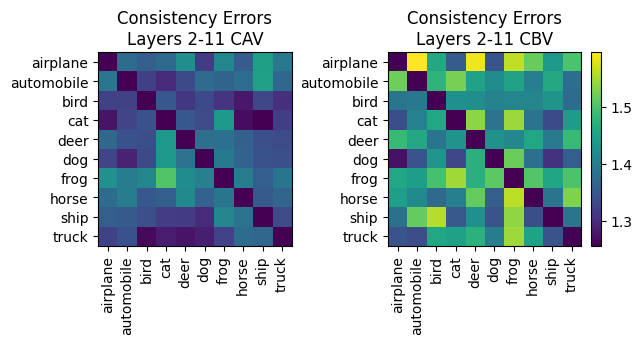

In [35]:
layer_1=2
layer_2=11

consistency_errors_cavs_file=open(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cavs','rb')
consistency_errors_cavs=pickle.load(consistency_errors_cavs_file)
consistency_errors_cavs_file.close()

consistency_errors_cbvs_file=open(f'{external_path}\\consistency_errors\\{layer_1}_{layer_2}\\consistency_errors_cbvs','rb')
consistency_errors_cbvs=pickle.load(consistency_errors_cbvs_file)
consistency_errors_cbvs_file.close()

fig,axs=plt.subplots(nrows=1,ncols=2,layout='constrained')

N=len(concepts)

errors_cav=np.ones((N,N))
errors_cbv=np.ones((N,N))

max_error=0
min_error=np.inf
for n,positive_concept in enumerate(concepts):
    for m,negative_concept in enumerate(concepts):
        if positive_concept==negative_concept:
            continue
        errors_cav[n,m]=consistency_errors_cavs[f'{positive_concept}_{negative_concept}']
        errors_cbv[n,m]=consistency_errors_cbvs[f'{positive_concept}_{negative_concept}']
        max_error=max(max_error,max(consistency_errors_cavs[f'{positive_concept}_{negative_concept}'],consistency_errors_cbvs[f'{positive_concept}_{negative_concept}']))
        min_error=min(min_error,min(consistency_errors_cavs[f'{positive_concept}_{negative_concept}'],consistency_errors_cbvs[f'{positive_concept}_{negative_concept}']))

im=axs[0].imshow(errors_cav,vmin=min_error,vmax=max_error)
im=axs[1].imshow(errors_cbv,vmin=min_error,vmax=max_error)
axs[0].set_xticks(range(N),labels=concepts,rotation='vertical')
axs[0].set_yticks(range(N),labels=concepts)
axs[0].set_title(f'Consistency Errors\nLayers {layer_1}-{layer_2} CAV')
axs[1].set_xticks(range(N),labels=concepts,rotation='vertical')
axs[1].set_yticks(range(N),labels=concepts)
axs[1].set_title(f'Consistency Errors\nLayers {layer_1}-{layer_2} CBV')
fig.colorbar(im,fraction=0.05)
plt.show()

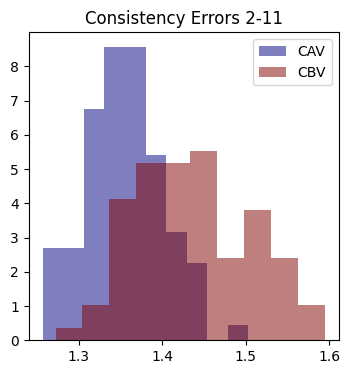

In [36]:
fig,axs=plt.subplots(nrows=1,ncols=1)
fig.set_figwidth(4)
fig.set_figheight(4)
colors = plt.cm.jet(np.linspace(0,1,2))
axs.hist(consistency_errors_cavs.values(),density=True,alpha=0.5,label='CAV',color=colors[0])
axs.hist(consistency_errors_cbvs.values(),density=True,alpha=0.5,label='CBV',color=colors[1])
axs.set_title(f'Consistency Errors {layer_1}-{layer_2}')
axs.legend()

plt.show()

In [4]:
aggregated_consistency_errors_cavs={}
aggregated_consistency_errors_cbvs={}
target_layer=11

if not(os.path.exists(f'{external_path}\\consistency_errors\\target_layer_{target_layer}_summary')):
    os.mkdir(f'{external_path}\\consistency_errors\\target_layer_{target_layer}_summary')

source_layers=[int(layer_to_layer.split('_')[0]) for layer_to_layer in os.listdir(f'{external_path}\\consistency_errors') if layer_to_layer.split('_')[1]==str(target_layer)]
source_layers.sort()

for source_layer in source_layers:
    consistency_errors_cavs_file=open(f'{external_path}\\consistency_errors\\{source_layer}_{target_layer}\\consistency_errors_cavs','rb')
    consistency_errors_cavs=pickle.load(consistency_errors_cavs_file)
    consistency_errors_cavs_file.close()

    consistency_errors_cbvs_file=open(f'{external_path}\\consistency_errors\\{source_layer}_{target_layer}\\consistency_errors_cbvs','rb')
    consistency_errors_cbvs=pickle.load(consistency_errors_cbvs_file)
    consistency_errors_cbvs_file.close()

    for concept_to_concept,error in consistency_errors_cavs.items():
        if concept_to_concept in aggregated_consistency_errors_cavs.keys():
            aggregated_consistency_errors_cavs[concept_to_concept].append(error)
        else:
            aggregated_consistency_errors_cavs[concept_to_concept]=[error]

    for concept_to_concept,error in consistency_errors_cbvs.items():
        if concept_to_concept in aggregated_consistency_errors_cbvs.keys():
            aggregated_consistency_errors_cbvs[concept_to_concept].append(error)
        else:
            aggregated_consistency_errors_cbvs[concept_to_concept]=[error]



for n,positive_concept in enumerate(concepts):
    for m,negative_concept in enumerate(concepts):
        if positive_concept==negative_concept:
            continue
        fig,axs=plt.subplots(nrows=1,ncols=1,layout='constrained')
        axs.plot(source_layers,aggregated_consistency_errors_cavs[f'{positive_concept}_{negative_concept}'],label='CAV',color='blue')
        axs.plot(source_layers,aggregated_consistency_errors_cbvs[f'{positive_concept}_{negative_concept}'],label='CBV',color='red')
        axs.set_xticks(source_layers)
        axs.set_xlabel('Source Layer')
        axs.set_ylabel('Consistency Error')
        axs.set_title(f'Consistency Error for with Target Layer {target_layer}\nFor {positive_concept}_{negative_concept} Concept Vectors')
        axs.legend()
        plt.savefig(f'{external_path}\\consistency_errors\\target_layer_{target_layer}_summary\\{positive_concept}_{negative_concept}_consistency_errors_across_layers.png')
        plt.close()